#Importar librerias y declaracion de funciones

In [63]:
#Importamos nuestras librerias

#Funciones de manejo de  Arrays y Matrices
import pandas as pd
import numpy as np


#Librerias de visualizacion de datos
import matplotlib.pyplot as plt
import seaborn as sns

#Otras Librerias
import os #Libreria para interactuar con el sistema operativo

In [64]:
def describe_datos(df):
    unicos =[]
    for col in df:
        unicos.append(df[col].unique())
    unicos = pd.Series(unicos, index=df.columns)
    descripcion = pd.concat([df.dtypes, df.isna().sum(),df.nunique(),unicos], axis=1)
    descripcion.columns = ['dtypes', 'null','nunique','unique' ]
    return(descripcion)

#Preparacion de datos y breve analisis exploratorio

##Lectura de datos y union de tabla de hechos

In [65]:
from pathlib import Path

#Definir Directorio
dir = 'FCT_INCIDENTS/'
output_name = 'incident_out.csv'
input_dir = Path(dir)

all_csv_data = []

for file_path in input_dir.glob('*.csv'):
    df = pd.read_csv(file_path)
    # Append the dataframe to the list
    all_csv_data.append(df)

df = pd.concat(all_csv_data, ignore_index=True)
output_path = Path(output_name)  # Ensure output is a Path object as well
df.to_csv(output_path, index=False)
#df

In [66]:

#Crear data frames dimensionales
dimCategory = pd.read_csv('DIM_CATEGORY.csv')
dimCompanny = pd.read_csv('DIM_COMPANY.csv')
dimState = pd.read_csv('DIM_INC_STATE.csv')
dimSubCategory = pd.read_csv('DIM_SUBCATEGORY.csv')
dimContactType = pd.read_csv('T_DIM_CONTACT_TYPE.csv')
dimDepartment = pd.read_csv('T_DIM_DEPARTMENT.csv')
dimEscalation = pd.read_csv('T_DIM_ESCALATION.csv')
dimSuppFunc = pd.read_csv('T_DIM_SUPPORT_FUNCTION.csv')
dimUser = pd.read_csv('T_DIM_NAMES.csv')
dimDepartment.dropna(inplace=True)


#Merge/Join archivos dimensionales con la fct
incidentes = df.merge(dimCategory, how='left')
incidentes = incidentes.merge(dimCompanny, how='left')
incidentes = incidentes.merge(dimState, how='left')
incidentes = incidentes.merge(dimSubCategory, how='left')
incidentes = incidentes.merge(dimContactType, how='left')

##Breve Analisis Exploratorio

##Preprosesamiento

In [ ]:




incidentes = incidentes.merge(
    dimUser[['FIRST_NAME','LAST_NAME','TITLE','DEPARTMENT','CALLER_SK']],
    left_on='OPENED_BY_SK',
    right_on= 'CALLER_SK'
    )

incidentes = incidentes.merge(
    dimUser[['FIRST_NAME','LAST_NAME','TITLE','DEPARTMENT','CALLER_SK']],
    left_on='RESOLVE_BY_SK',
    right_on= 'CALLER_SK',
    suffixes=(None,'_R'),
    how='left'
    )

incidentes = incidentes.merge(
    dimDepartment,
    left_on='DEPARTMENT',
    right_on='DEPARTMENT',
    suffixes=(None,'_O'),
    how='left'
    )
print(incidentes['INCIDENT_NUMBER'].count())
incidentes = incidentes.merge(
    dimDepartment,
    left_on='DEPARTMENT_R',
    right_on='DEPARTMENT',
    suffixes=(None,'_R'),
    how='left'
    )
dimEscalation['INC_ESCALATION_SK'] = pd.to_numeric(dimEscalation['INC_ESCALATION_SK'], errors='coerce').astype('Int64')
incidentes = incidentes.merge(dimEscalation, how='left')
incidentes = incidentes.merge(dimSuppFunc, how='left')

incidentes.drop(columns=['INC_STATE_SK',
                         'CATEGORY_SK',
                         'OPENED_BY_SK',
                         'RESOLVE_BY_SK',
                         'SUPPORT_FUNCTION_SK',
                         'CONTACT_TYPE_SK',
                         'INC_ESCALATION_SK',
                         'DEPARTMENT',
                         'DEPARTMENT_R',
                         'CALLER_SK',
                         'CALLER_SK_R',
                         'COMPANY_SK',
                         'SUBCATEGORY_SK',
                         'Year',
                         'Month'],
                inplace=True)

# Convertir las columnas de fechas a datetime
incidentes['CREATED_DTTM'] = pd.to_datetime(incidentes['CREATED_DTTM'])
incidentes['RESOLVED_AT_DTTM'] = pd.to_datetime(incidentes['RESOLVED_AT_DTTM'])
incidentes['DAY'] = incidentes['CREATED_DTTM'].dt.day
incidentes['MONTH'] = incidentes['CREATED_DTTM'].dt.month
incidentes['YEAR'] = incidentes['CREATED_DTTM'].dt.year
incidentes['DAY_NAME'] = incidentes['CREATED_DTTM'].dt.day_name()
incidentes['HOUR'] = incidentes['CREATED_DTTM'].dt.hour

# Calcular el tiempo de resolución

# Calcular el tiempo de resolución
incidentes['RESOLUTION_TIME'] = incidentes['RESOLVED_AT_DTTM'] - incidentes['CREATED_DTTM']

#incidentes['RESOLUTION_TIME'] =

incidentes.head(10)
#describe_datos(incidentes)

31372


#MTTR Mean Time To Resolve

In [68]:
# Calcular el MTTR
mean_inc = incidentes['RESOLUTION_TIME'].mean()
mean_inc

Timedelta('2 days 19:20:45.858096828')

#SD Resolvable %

In [69]:
# Filtrar los incidentes cerrados y con resolver level 1
mean_lvl_1 = incidentes[incidentes['RESOLVED_FIRST_CONTACT'] == 1].shape[0]
mean_lvl_1 / incidentes.shape[0]
#mean_lvl_1.count()

# Calcular el porcentaje de resolución por el Service Desk

0.3775978579625143

#Closed Percentage by Month

#Visuales

##Heatmap

In [70]:
# Crear el heatmap Resolution Time Month vs Company


##Displot

In [71]:
#Distribution Plot for company by month


##Violinplot

##Grafica de columnas apiladas al 100%(Tickets abiertos vs tickets resueltos o cerrados)

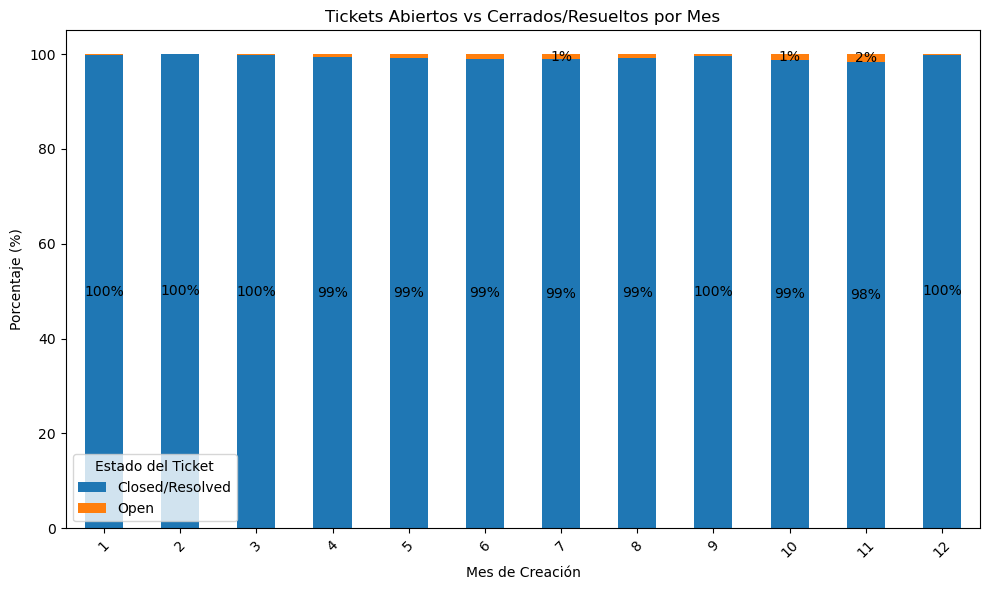

In [72]:
# Filtrar los incidentes abiertos y cerrados o resueltos
incidentes['STATUS'] = np.where(
    incidentes['INC_STATE'].isin(['Closed', 'Resolved']),
    'Closed/Resolved',
    'Open'
)

# Agrupar por mes y estado
status_summary = incidentes.groupby(['MONTH', 'STATUS']).size().unstack(fill_value=0)

# Calcular el porcentaje para cada estado por mes
status_summary_percentage = status_summary.div(status_summary.sum(axis=1), axis=0) * 100

# Crear la gráfica de columnas apiladas al 100%
ax = status_summary_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Tickets Abiertos vs Cerrados/Resueltos por Mes')
plt.xlabel('Mes de Creación')
plt.ylabel('Porcentaje (%)')
plt.legend(title='Estado del Ticket')
plt.xticks(rotation=45)

# Agregar etiquetas con los valores en porcentaje a 2 dígitos, no mostrar si el valor es menor a 1%
for bars in ax.containers:
    labels = [f'{v:.0f}%' if v >= 1 else '' for v in bars.datavalues]
    ax.bar_label(bars, labels=labels, label_type='center')

plt.tight_layout()
plt.show()

<Axes: >

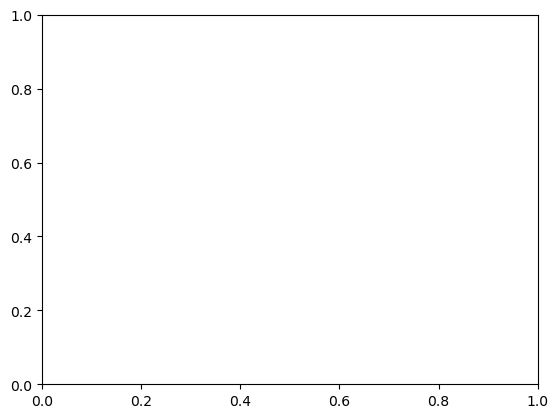

In [73]:
sns.barplot()